In [ ]:
!pip install langdetect

     |████████████████████████████████| 983kB 5.3MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=a53617966de356cdeac78a072ffe7b248d96e739cbbb1dacf15d7b56141c1c8f
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7ddc6c92d3aa015cf1a498df5a70268996
Successfully built langdetect


In [ ]:
!pip install google-trans-new

### Preproc

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(16,12)})

import langdetect
import string
import re
import spacy
import ast
import collections
import itertools

import nltk
from nltk import bigrams
import networkx as nx
from wordcloud import WordCloud


In [ ]:
import tensorflow as tf
import os

In [ ]:
train1 = pd.read_csv("semisupervised.csv")
train2 = pd.read_csv("SEC-Bantuan-Corona.csv")

In [ ]:
train1=train1.drop(['Unnamed: 0','Tweets'],axis=1)

In [ ]:
train2=train2.drop(['Tweet_count','got_criteria'],axis=1)

In [ ]:
train1.head()

,Bulan,Province,Tweet_clean,Prediksi
0,6,Jakarta,penanganan pandemi covid butuh nilai nilai pan...,0
1,6,Jakarta,penanganan pandemi covid butuh nilai nilai pan...,0
2,6,Jakarta,begitu kenapa paling butuh duid masa pandemi ...,0
3,6,Jakarta,imo gapapa banget nder menurutku di daring gin...,0
4,6,Jakarta,saya bukan gitu si tapi lebih ke saya butuh or...,0


In [ ]:
train2.head()

,Bulan,Province,Labels,Tweets
0,3,Banten,0,#bantuanapd #bantuan #COVID19 #COVID19indonesi...
1,3,Banten,1,"#Covid19 #Bantuan Rencananya, bantuan yang aka..."
2,3,Banten,0,#pkpday10 #bantuan #stayathome #covid19 https:...
3,3,Banten,3,@Kemhan_RI @Kemlu_RI @Menlu_RI @jokowi @BNPB_I...
4,3,Banten,3,5.000 Masker CSR LPPOM MUI bersama PT Arista L...


In [ ]:
train2

,Bulan,Province,Tweet_clean,Prediksi
0,6,Jakarta,penanganan pandemi covid butuh nilai nilai pan...,0
1,6,Jakarta,penanganan pandemi covid butuh nilai nilai pan...,0
2,6,Jakarta,begitu kenapa paling butuh duid masa pandemi ...,0
3,6,Jakarta,imo gapapa banget nder menurutku di daring gin...,0
4,6,Jakarta,saya bukan gitu si tapi lebih ke saya butuh or...,0
...,...,...,...,...
29945,4,Jawa Tengah,buka sekarang juga tidak masalah tetap utamaka...,0
29946,4,Jawa Tengah,masyarakat bertoleransi kepulangan pmi di teng...,0
29947,4,Jawa Tengah,kepulangan pmi di tengah pandemi covid sehingg...,0
29948,4,Jawa Tengah,tulisan awalnya sudah menulis american mbak ti...,0


In [ ]:
train2 = train1.rename(columns={'Labels': 'Prediksi', 'Tweets': 'Tweet_clean'})

In [ ]:
sample = [train1,train2]
train = pd.concat(sample)

In [ ]:
train

,Bulan,Province,Tweet_clean,Prediksi
0,6,Jakarta,penanganan pandemi covid butuh nilai nilai pan...,0
1,6,Jakarta,penanganan pandemi covid butuh nilai nilai pan...,0
2,6,Jakarta,begitu kenapa paling butuh duid masa pandemi ...,0
3,6,Jakarta,imo gapapa banget nder menurutku di daring gin...,0
4,6,Jakarta,saya bukan gitu si tapi lebih ke saya butuh or...,0
...,...,...,...,...
29945,4,Jawa Tengah,buka sekarang juga tidak masalah tetap utamaka...,0
29946,4,Jawa Tengah,masyarakat bertoleransi kepulangan pmi di teng...,0
29947,4,Jawa Tengah,kepulangan pmi di tengah pandemi covid sehingg...,0
29948,4,Jawa Tengah,tulisan awalnya sudah menulis american mbak ti...,0


In [ ]:
file = open("arkav/combined_slang_words.txt")
content = file.read()
dicti = ast.literal_eval(content)
slang = pd.DataFrame(dicti.items(),columns=['original','replacement'])
slang.head()

,original,replacement
0,sdgkn,sedangkan
1,maem,makan
2,sambat,mengeluh
3,bcanda,bercanda
4,bener,benar


In [ ]:
import re

def remove_float(text):
  final_text = ''
  if isinstance(text,float) or isinstance(text,int):
    return final_text
  else:
    return text

def filter(text):
    final_text = ''
    for word in text.split():
        if word.startswith('@'):
            continue
        elif word[-3:] in ['com', 'org']:
            continue
        elif word.startswith('pic') or word.startswith('http') or word.startswith('www'):
            continue
        else:
            final_text += word+' '
    return final_text

def lowercase(text):
    return text.lower()

def remove_repeated_char(text):
    return ' '.join([re.sub(r'(.+?)\1+$', r'\1\1',word) for word in text.split(' ')])

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
     # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^a-zA-Z]+', ' ', text) 
    return text

slang_dict_map = dict(zip(slang['original'], slang['replacement']))
def normalize_alay(text):
    return ' '.join([slang_dict_map[word] if word in slang_dict_map else word for word in text.split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopwords.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def convert_emojis(text):
    for emot in UNICODE_EMO:
        text = text.replace(emot, "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").split()))
    return text

def miss_to_na(text):
  final_text = pd.NA
  if text == '':
    return final_text
  else:
    return text

PUNCT_TO_REMOVE = '"#$%^*()_+-=<>;[]|{}~:â€™¦£?'
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

In [ ]:
def preprocess(text):
    text = filter(text)
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = remove_repeated_char(text)
    text = normalize_alay(text) # 3
    text = miss_to_na(text)
    return text

In [ ]:
train['Tweet_clean'] = train['Tweet_clean'].apply(preprocess)

In [ ]:
train['lang'] = train["Tweet_clean"].apply(lambda x: langdetect.detect(x) if 
                                 x.strip() != "" else "")

In [ ]:
i=train[train['Tweet_clean']==' '].index

In [ ]:
train.drop(i,inplace=True)

In [ ]:
#train.to_csv('tweet suicide prepros.csv', index=False, header=True)

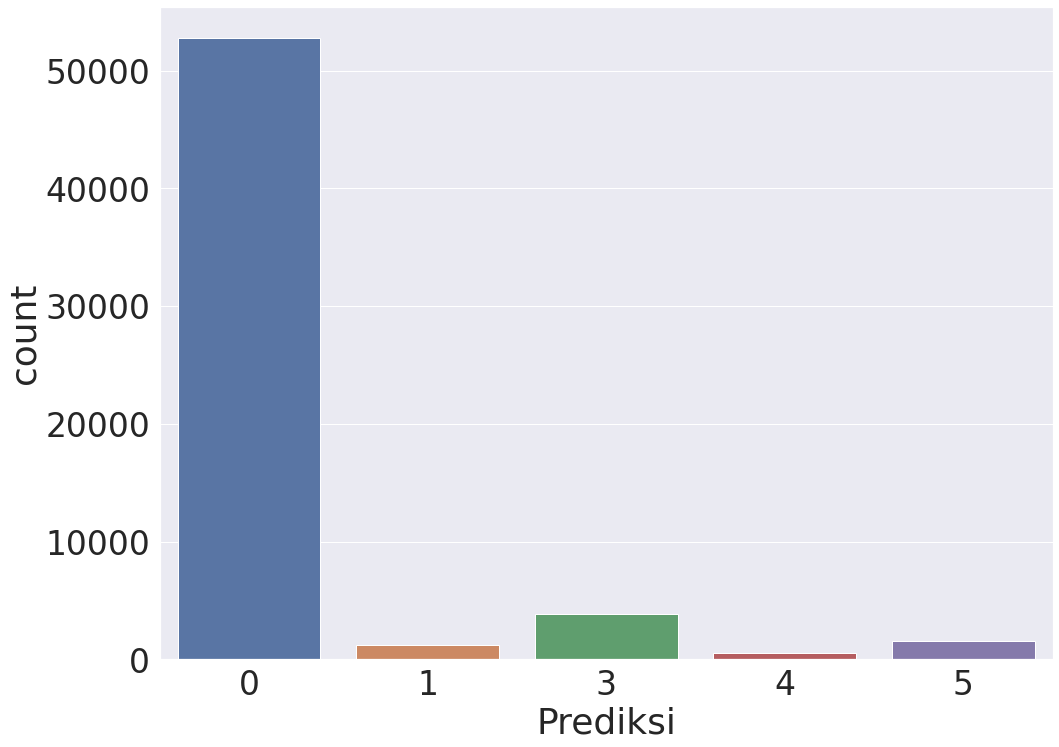

In [ ]:
sns.countplot(x='Prediksi',data=train)

In [ ]:
train=train[train['Prediksi']<9]

In [ ]:
train['Prediksi'].unique()

array([0, 1, 3, 5, 4])

### Buat yang Bantuan Non Bantuan

In [ ]:
trainnew=train

In [ ]:
trainnew['Prediksi']=train['Prediksi'].replace({2: 1})

In [ ]:
trainnew['Prediksi'].unique()

array([0, 1])

In [ ]:
trainnew['Prediksi']=trainnew['Prediksi'].replace({3: 1})
trainnew['Prediksi']=trainnew['Prediksi'].replace({4: 1})
trainnew['Prediksi']=trainnew['Prediksi'].replace({5: 1})

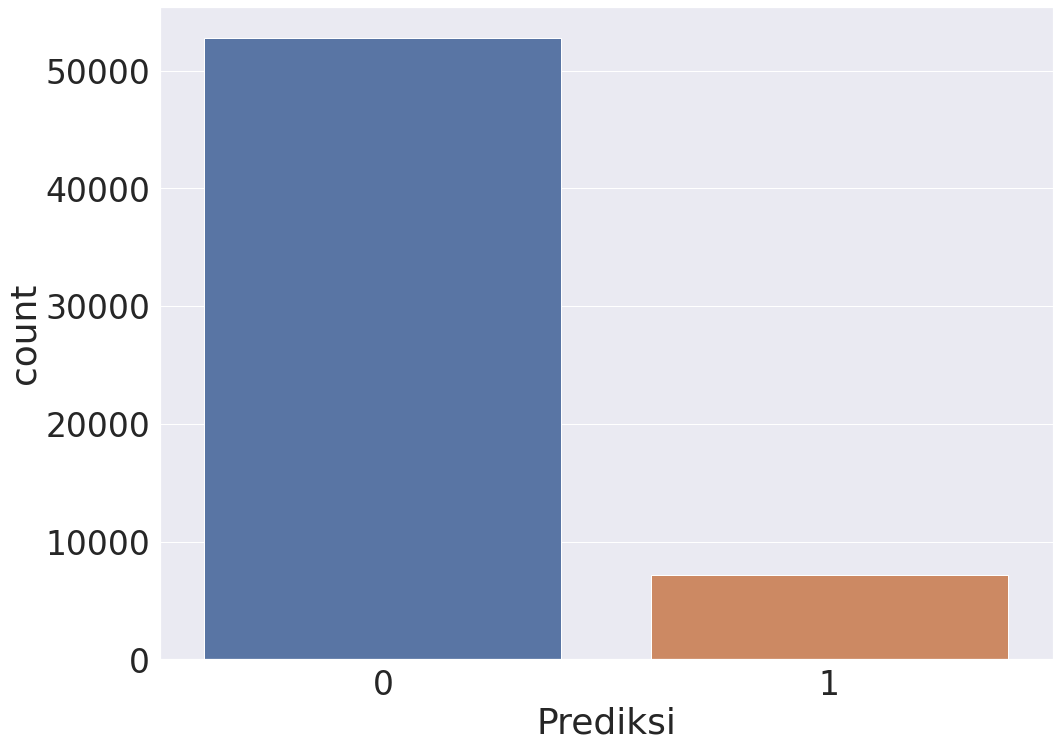

In [ ]:
sns.set(font_scale=3)
sns.countplot(x='Prediksi',data=trainnew)

In [ ]:
x = trainnew['Tweet_clean']
y = trainnew['Prediksi']

### Buat Jenis2 Bantuan

In [ ]:
trainnew2=train

In [ ]:
trainnew2=trainnew2[trainnew2['Prediksi']>0]

In [ ]:
x = trainnew2['Tweet_clean']
y = trainnew2['Prediksi']

In [ ]:
y.unique()

array([0, 1, 3, 2])

In [ ]:
trainnew2['Prediksi']=trainnew2['Prediksi'].replace({1: 0})
trainnew2['Prediksi']=trainnew2['Prediksi'].replace({3: 1})
trainnew2['Prediksi']=trainnew2['Prediksi'].replace({4: 2})
trainnew2['Prediksi']=trainnew2['Prediksi'].replace({5: 3})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

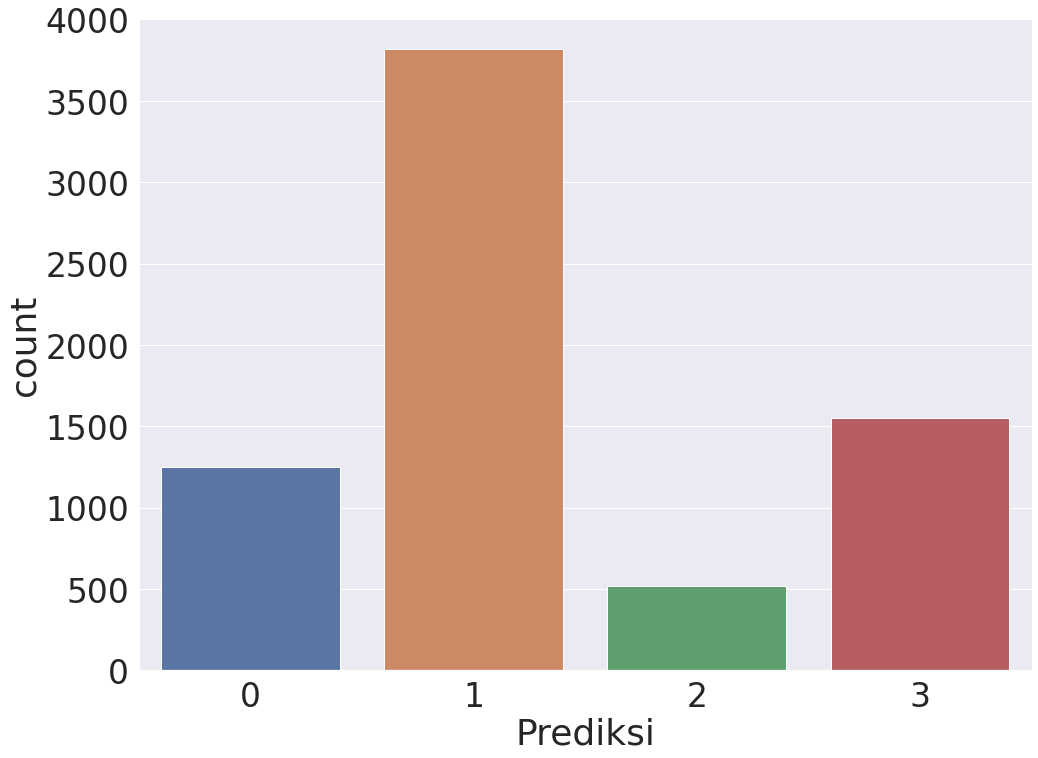

In [ ]:
sns.set(font_scale=3)
sns.countplot(x='Prediksi',data=trainnew2)

### BERT

In [ ]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.95.244.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.95.244.90:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 5.2MB/s 
     |████████████████████████████████| 901kB 39.1MB/s 
     |████████████████████████████████| 3.3MB 35.6MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AlbertTokenizer, TFBertForSequenceClassification, BertConfig
import torch
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
MAX_LEN =50
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=42,stratify=y_test)

In [ ]:
!pip install sentencepiece

In [ ]:
indolarge = 'indobenchmark/indobert-large-p2'
tokenizer = BertTokenizer.from_pretrained(indolarge, do_lower_case=True, add_special_tokens=True, max_length=64, pad_to_max_length=True)

In [ ]:
from tqdm import tqdm
def tokenize(sentences,tokenizer):
  input_ids, input_masks, input_segments = [],[],[]
  for sentence in tqdm(sentences):
    inputs = tokenizer.encode_plus(str(sentence), add_special_tokens=True, max_length=64,
                                   pad_to_max_length = True, return_attention_mask=True,
                                   return_token_type_ids=True)
    input_ids.append(inputs['input_ids'])
    input_masks.append(inputs['attention_mask'])
    input_segments.append(inputs['token_type_ids'])
  return np.asarray(input_ids,dtype='int32'),np.asarray(input_masks,dtype='int32'),np.asarray(input_segments,dtype='int32')

In [ ]:
train_input, train_mask, tokenized = tokenize(x_train, tokenizer)
val_input, val_mask, tokenized_val = tokenize(x_val, tokenizer)

100%|██████████| 5990/5990 [00:06<00:00, 948.36it/s]


In [ ]:
tf.constant(val_input).shape[0]//32

187

In [ ]:
with strategy.scope():
  config = BertConfig.from_pretrained(indolarge,output_attentions=False,hidden_dropout_prob=0.2,attention_probs_dropout_prob=0.2,num_labels=64)
  config.output_hidden_states=False
  transformer_model = TFBertForSequenceClassification.from_pretrained(indolarge, config=config)
  input_ids = tf.keras.layers.Input(shape=(64,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(64,), name='masked_token', dtype='int32')
  embedding_layer = transformer_model(input_ids, attention_mask=input_masks_ids, training=True)[0]
  X = tf.keras.layers.Dense(50, activation='relu')(embedding_layer)
  X = tf.keras.layers.Dropout(0.3)(X)
  X = tf.keras.layers.Dense(2, activation='softmax')(X) #Output disesuaiin sama jumlah kategori di variabel dependen, contoh 3 disini berarti ada 3 kategori
  model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
  model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history=model.fit([tf.constant(train_input),tf.constant(train_mask)],
                  y_train,
                  batch_size=32,
                  epochs=4,
                  validation_data=([tf.constant(val_input),tf.constant(val_mask)],y_val),
                  validation_steps=7
)

Epoch 1/4


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


1498/1498 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9377

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


1498/1498 [==============================] - 489s 224ms/step - loss: 0.1601 - accuracy: 0.9377 - val_loss: 0.1057 - val_accuracy: 0.9643
Epoch 2/4
1498/1498 [==============================] - 237s 158ms/step - loss: 0.0842 - accuracy: 0.9689 - val_loss: 0.0631 - val_accuracy: 0.9732
Epoch 3/4
1498/1498 [==============================] - 237s 158ms/step - loss: 0.0578 - accuracy: 0.9801 - val_loss: 0.0471 - val_accuracy: 0.9866
Epoch 4/4
1498/1498 [==============================] - 238s 159ms/step - loss: 0.0481 - accuracy: 0.9830 - val_loss: 0.1287 - val_accuracy: 0.9688


In [ ]:
test_input, test_mask, tokenized_test = tokenize(x_test, tokenizer)

100%|██████████| 5990/5990 [00:06<00:00, 916.98it/s]


In [ ]:
predik2 = model.predict([tf.constant(test_input),tf.constant(test_mask)],batch_size=12)
newp2 = predik2.argmax(axis=-1)
print(classification_report(y_test, newp2, digits=4))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


              precision    recall  f1-score   support

           0     0.9876    0.9824    0.9850      5276
           1     0.8747    0.9090    0.8915       714

    accuracy                         0.9736      5990
   macro avg     0.9311    0.9457    0.9382      5990
weighted avg     0.9742    0.9736    0.9738      5990



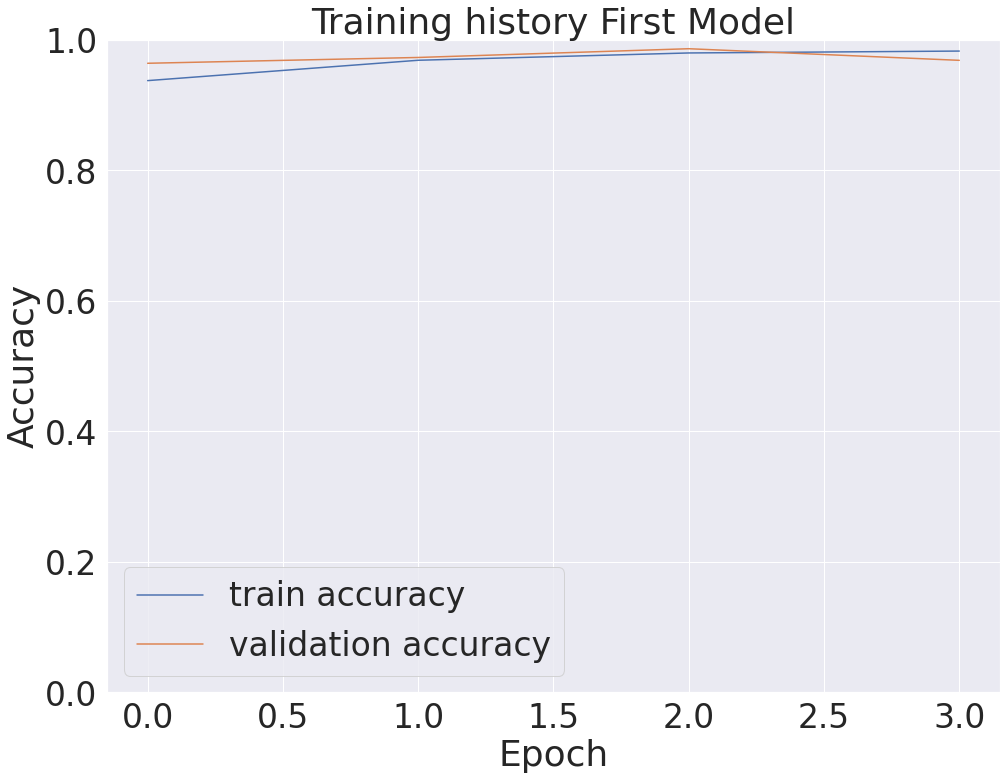

In [ ]:
train_acc = [0.9377,0.9689,0.9801,0.9830]
val_acc = [0.9643,0.9732,0.9866,0.9688]
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history First Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

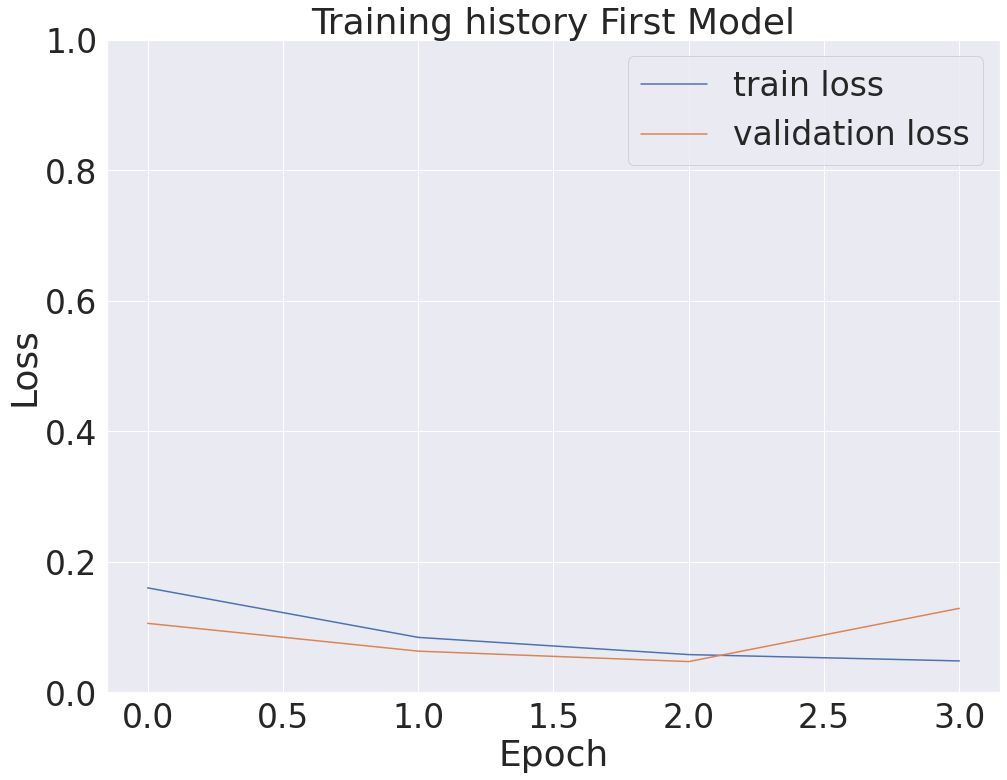

In [ ]:
train_loss = [0.1601,0.0842,0.0578,0.0481]
val_loss = [0.1057,0.0631,0.0471,0.1287]
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')

plt.title('Training history First Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

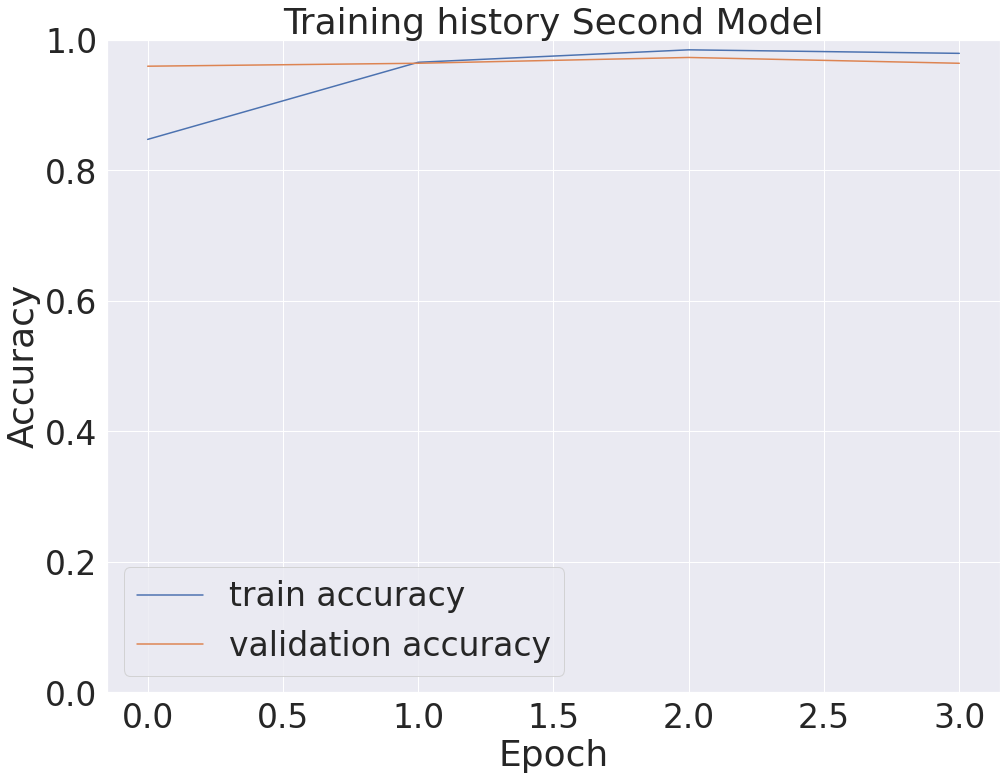

In [ ]:
train_acc = [0.8476,0.9658,0.9849,0.9795]
val_acc = [0.9598,0.9643,0.9732,0.9643]
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history Second Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

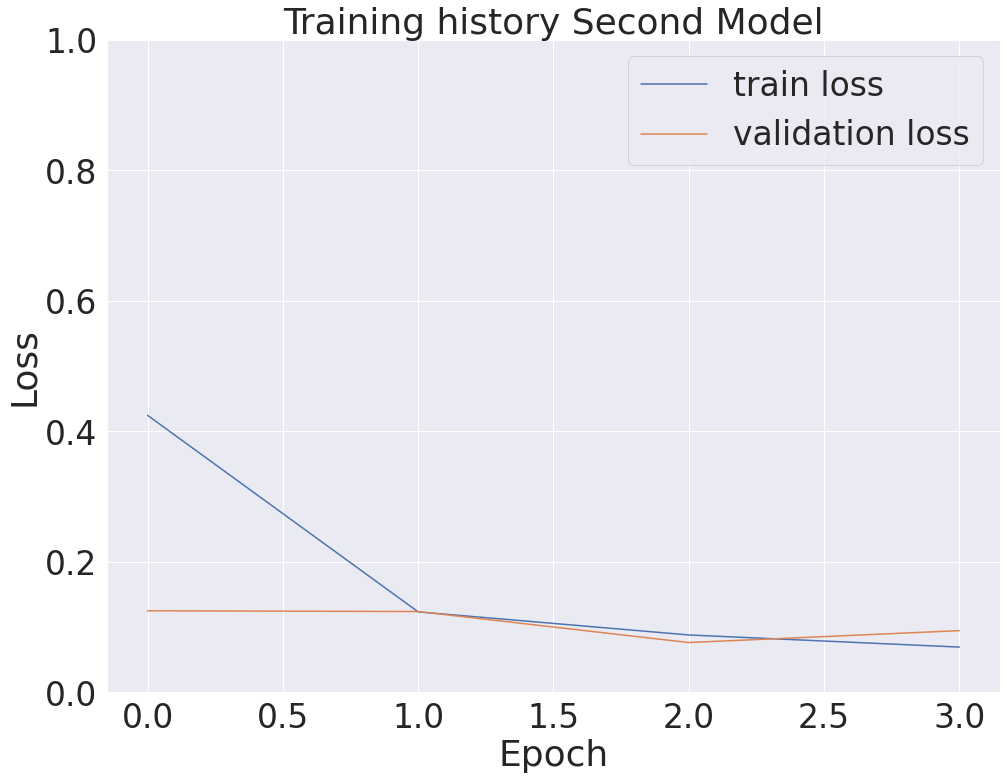

In [ ]:
train_loss = [0.4245,0.1233,0.0879,0.0693]
val_loss = [0.1250,0.1238,0.0763,0.0945]
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')

plt.title('Training history Second Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
x_test

24      mjb kak mau bertanya tadi laptop aku tiba tiba...
9       player bagus macam adik paul ini cemana deme b...
1432    kamu tahu tidak sih saya tuh capek banget stre...
1138    kadang makannya kesel sm yang sudah punya priv...
1095    tidak tahu kok saya hidup aneh banget deh anji...
                              ...                        
1682    ketika saya ingin self harm atau bunuh diri pa...
2071                        ingin mati saja yaallah wkwk 
1396    saya lihat ini sedih seperti ingin bunuh diri ...
1915    sedih iya hopeless ingin banget nyerah pada de...
102     tbtb keinget dulu waktu dia berjuang mati mati...
Name: Content, Length: 230, dtype: object

In [ ]:
newp2

array([1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 0, 1, 2, 1, 0, 2, 0,
       1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2,
       1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0,
       2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1,
       0, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 0, 0, 2, 2,
       0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1,
       1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 0, 0, 0,
       0, 1, 2, 1, 1, 2, 2, 0, 2, 1])

### BERT2

In [ ]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.24.159.194:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.24.159.194:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
strategy = tf.distribute.TPUStrategy(resolver)

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
!pip install transformers

     |████████████████████████████████| 2.5MB 5.3MB/s 
     |████████████████████████████████| 901kB 38.6MB/s 
     |████████████████████████████████| 3.3MB 36.3MB/s 


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AlbertTokenizer, TFBertForSequenceClassification, BertConfig
import torch
from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
MAX_LEN =50
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
x_test, x_val, y_test, y_val = train_test_split(x_test,y_test,test_size=0.5,random_state=42,stratify=y_test)

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 5.3MB/s 


In [ ]:
indolarge = 'indobenchmark/indobert-large-p2'
tokenizer = BertTokenizer.from_pretrained(indolarge, do_lower_case=True, add_special_tokens=True, max_length=64, pad_to_max_length=True)

In [ ]:
from tqdm import tqdm
def tokenize(sentences,tokenizer):
  input_ids, input_masks, input_segments = [],[],[]
  for sentence in tqdm(sentences):
    inputs = tokenizer.encode_plus(str(sentence), add_special_tokens=True, max_length=64,
                                   pad_to_max_length = True, return_attention_mask=True,
                                   return_token_type_ids=True)
    input_ids.append(inputs['input_ids'])
    input_masks.append(inputs['attention_mask'])
    input_segments.append(inputs['token_type_ids'])
  return np.asarray(input_ids,dtype='int32'),np.asarray(input_masks,dtype='int32'),np.asarray(input_segments,dtype='int32')

In [ ]:
train_input, train_mask, tokenized = tokenize(x_train, tokenizer)
val_input, val_mask, tokenized_val = tokenize(x_val, tokenizer)

100%|██████████| 714/714 [00:00<00:00, 776.62it/s]


In [ ]:
tf.constant(val_input).shape[0]//32

22

In [ ]:
with strategy.scope():
  config = BertConfig.from_pretrained(indolarge,output_attentions=False,hidden_dropout_prob=0.2,attention_probs_dropout_prob=0.2,num_labels=64)
  config.output_hidden_states=False
  transformer_model = TFBertForSequenceClassification.from_pretrained(indolarge, config=config)
  input_ids = tf.keras.layers.Input(shape=(64,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(64,), name='masked_token', dtype='int32')
  embedding_layer = transformer_model(input_ids, attention_mask=input_masks_ids, training=True)[0]
  X = tf.keras.layers.Dense(50, activation='relu')(embedding_layer)
  X = tf.keras.layers.Dropout(0.3)(X)
  X = tf.keras.layers.Dense(4, activation='softmax')(X) #Output disesuaiin sama jumlah kategori di variabel dependen, contoh 3 disini berarti ada 3 kategori
  model = tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
  model.compile(loss=loss,optimizer=optimizer,metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-large-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
history=model.fit([tf.constant(train_input),tf.constant(train_mask)],
                  y_train,
                  batch_size=32,
                  epochs=4,
                  validation_data=([tf.constant(val_input),tf.constant(val_mask)],y_val),
                  validation_steps=7
)

Epoch 1/4


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


179/179 [==============================] - ETA: 0s - loss: 0.4245 - accuracy: 0.8476

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None,) dtype=int64>]


179/179 [==============================] - 279s 705ms/step - loss: 0.4245 - accuracy: 0.8476 - val_loss: 0.1250 - val_accuracy: 0.9598
Epoch 2/4
179/179 [==============================] - 29s 160ms/step - loss: 0.1233 - accuracy: 0.9658 - val_loss: 0.1238 - val_accuracy: 0.9643
Epoch 3/4
179/179 [==============================] - 29s 160ms/step - loss: 0.0879 - accuracy: 0.9749 - val_loss: 0.0763 - val_accuracy: 0.9732
Epoch 4/4
179/179 [==============================] - 29s 160ms/step - loss: 0.0693 - accuracy: 0.9795 - val_loss: 0.0945 - val_accuracy: 0.9643


In [ ]:
test_input, test_mask, tokenized_test = tokenize(x_test, tokenizer)

100%|██████████| 714/714 [00:00<00:00, 799.62it/s]


In [ ]:
predik2 = model.predict([tf.constant(test_input),tf.constant(test_mask)],batch_size=12)
newp2 = predik2.argmax(axis=-1)
print(classification_report(y_test, newp2, digits=4))

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 64) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 64) dtype=int32>]


              precision    recall  f1-score   support

           0     0.9370    0.9520    0.9444       125
           1     0.9896    0.9974    0.9935       382
           2     0.9107    0.9808    0.9444        52
           3     0.9932    0.9355    0.9635       155

    accuracy                         0.9748       714
   macro avg     0.9576    0.9664    0.9615       714
weighted avg     0.9754    0.9748    0.9748       714



In [ ]:
x_test

24      mjb kak mau bertanya tadi laptop aku tiba tiba...
9       player bagus macam adik paul ini cemana deme b...
1432    kamu tahu tidak sih saya tuh capek banget stre...
1138    kadang makannya kesel sm yang sudah punya priv...
1095    tidak tahu kok saya hidup aneh banget deh anji...
                              ...                        
1682    ketika saya ingin self harm atau bunuh diri pa...
2071                        ingin mati saja yaallah wkwk 
1396    saya lihat ini sedih seperti ingin bunuh diri ...
1915    sedih iya hopeless ingin banget nyerah pada de...
102     tbtb keinget dulu waktu dia berjuang mati mati...
Name: Content, Length: 230, dtype: object

In [ ]:
newp2

array([1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 0, 1, 0, 1, 2, 1, 0, 2, 0,
       1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2,
       1, 1, 2, 2, 2, 1, 2, 1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 0,
       2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1,
       0, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 1, 2, 0, 0, 2, 2,
       0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 0, 1, 1, 1, 2, 2, 1,
       1, 0, 1, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 0, 0, 0,
       0, 1, 2, 1, 1, 2, 2, 0, 2, 1])